# Pràctica 4: SVM


In [10]:
import dask as d
import numpy as np
import skimage.io as s
import sklearn as sk
from sklearn.utils import shuffle
from skimage.transform import downscale_local_mean


print(d.__version__, np.__version__, skimage.__version__, sk.__version__)

2.30.0 1.19.4 0.17.2 0.23.2


## Avaluació i entregues

### Entregues
Les pràctiques es realitzarán els divendres de 15:00 a 17:00. Cada setmana presentarem nous mètodes i algorismes vistos a la classe de teoria.

L'entrega, es realitzarà el següent dijous abans de les 23:59, és a dir, tindreu les hores de classe més tota una setmana per a realitzar les tasques. Es pujará un .ipynb ja executat, on no només hi hagi codi sinó també text explicatiu de gràfiques, resultats, i analisis. Tingueu en compte que no es valora tant la quantitat, sino la qualitat del que s'hi explica. Hem d'aprendre a extreure el gra de la palla i presentar-ho de forma correcta i concisa.


### Avaluació
Aquesta práctica será molt més dirigida que l'anterior. S'evaluarán els següents conceptes sobre una mateixa base de dades, que tractarà sobre els vins:

* A. SVM (20%)
* B. ROC curve vs PR (30%)
* C. Crossvalidation (30%)
* D. Hyperparameter search (20%)


### Dataset
Per aquesta pràctica hem decidit treballar amb una base de dades de imatges. Es tracta de [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist). És similar a la base de dades de MNIST, un dataset clàssic en la visió per computador. Són imatges de 28x28 pixels i en escala de grisos. El original disposa de 60.000 imatges de entrenament i 10.000 de test. Està anotat en 10 categories diferents:

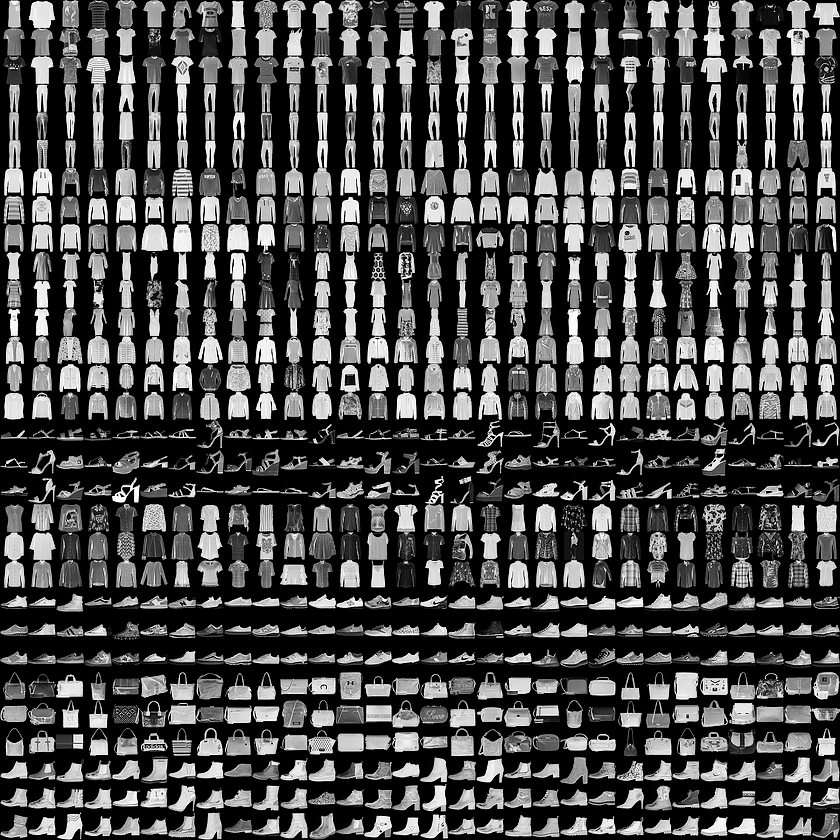

|Id|Nom|
|:-:|:--|
|0|T-shirt/top 
|1|Trouser |
|2|Pullover| 
|3|Dress|
|4|Coat|
|5|Sandal|
|6|Shirt|
|7|Sneaker|
|8|Bag |
|9|Ankle boot|


Ens hem descarregat el csv desde: https://www.kaggle.com/zalando-research/fashionmnist.

Els hem simplificat i dividit en altres csv més petits. Tenim els originals, i llavors un subsampling (100 vegades més petit). Dels petits, a més, també tenim el cas binari.

| nom | set | # exemples | # categories |
|:--|:-:|:-:|:-:|
|fashion-mnist_train_small_binary.csv   |train|     600 |  2 |
|fashion-mnist_test_small_binary.csv    |test |     100 |  2 |
|fashion-mnist_train_small.csv          |train|     600 | 10 |
|fashion-mnist_test_small.csv           |test |     100 | 10 |
|fashion-mnist_train.csv                |train|  60.000 | 10 |
|fashion-mnist_test.csv                 |test |  10.000 | 10 |

Les dues originals, les podeu *descarregar* del link de [Kaggle](https://www.kaggle.com/zalando-research/fashionmnist?select=fashion-mnist_train.csv). Son uns 150MB una vegada descomprimits.


In [26]:
# Importar llibreries i obrir el dataset

import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
# sns.set_theme()

# Visualitzarem només 3 decimals per mostra, i definim el num de files i columnes a mostrar
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 50)

# Funcio per a llegir dades en format csv
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

# Carreguem dataset d'exemple
dataset = load_dataset('fashion-mnist_train_small_binary.csv')
y_train = dataset["label"]
X_train = dataset.drop("label", axis="columns")

dataset_test = load_dataset('fashion-mnist_test_small_binary.csv')
y_test = dataset_test["label"]
X_test = dataset_test.drop("label", axis="columns")


print("Dimensionalitat de la BBDD:", dataset.shape)
# http://fashion-mnist.s3-website.eu-central-1.amazonaws.com

Dimensionalitat de la BBDD: (600, 785)


In [27]:
dataset

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,...,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,...,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,...,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,5,4,5,5,3,5,6,2,0,0,0,0,0,0,0,2,3,7,4,4,5,...,4,0,0,0,2,4,9,7,8,7,5,4,8,12,5,7,8,7,4,3,7,5,0,0,0
6,1,0,0,0,0,0,0,0,0,0,0,0,0,159,161,143,180,142,21,0,0,0,0,0,0,...,0,0,0,0,0,0,0,7,36,50,51,68,48,48,33,14,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,3,2,0,0,60,234,215,229,223,231,107,0,0,0,0,4,0,0,...,1,76,88,35,0,0,2,5,7,3,3,3,3,7,5,1,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,141,45,0,1,0,0,0,0,0,0,...,0,0,3,0,0,220,215,210,198,185,188,194,177,189,198,203,214,166,0,0,0,0,0,0,0


## A. SVM (20%)

L'objectiu d'aquest apartat es familiaritzar-se amb el modul de [SVM de sklearn](https://scikit-learn.org/stable/modules/svm.html).

En aquest apartat només farem servir les dades **fashion-mnist_train_small_binary.csv**	i **fashion-mnist_train_small.csv**



Bàsicament tenim a dos models: el [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) i el [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)

#### SVC

El model SVC está implementat a través de libsm. El temps d'entrenament escala almenys **quadràticament** amb el número de exemples.

A més, el multiclass s'implementa amb la estratègia One-Vs-One (OVO).

Tot i així, ens permet fer servir varis **kernels**: 
* ‘linear’
* ‘poly’ 
* ‘rbf’ (default)
* ‘sigmoid’ 
* ‘precomputed’ 

Mireu quins parametres apliquen a cada un dels kernels a la seva [documentació](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

*EL FAREM SERVIR QUAN TENIM **POCS EXEMPLES**, O MOLT DE TEMPS..*

#### LinearSVC

El model SVC está implementat a través de liblinear. Hauria de permetre treballar amb més dades (escala molt millor amb el número d'exemples).

A més, el multiclass s'implementa amb la estratègia One-Vs-Rest (OVR)

*EL FAREM SERVIR QUAN TENIM **MOLTS EXEMPLES** i el temps de SVC es intractable*




Recordeu el que significa One-Vs-One (OVO) i One-Vs-Rest (OVR)

<img src="https://machinelearningwithmlr.files.wordpress.com/2019/10/ch06_fig_8_mlr.png?w=584">


Exemple de SVC:

In [28]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC, LinearSVC
import time
from sklearn.model_selection import train_test_split


start = time.time()
clf = make_pipeline(StandardScaler(), SVC(C=1,kernel="linear"))
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_train_scr = clf.decision_function(X_train) #fer sigmoide per buscar prob de categoria
y_test_scr = clf.decision_function(X_test) 


"""   DESCREIURE PARÀMETRES"""

accuracy_train = accuracy_score(y_train, y_train_pred)
y_test_pred = clf.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
print("The accuracy on test is {}".format(accuracy_test))


print("Time is {} ".format(time.time()-start))
print("The accuracy on training is {}".format(accuracy_train))
print("The accuracy on test is {}".format(accuracy_test))
clf

The accuracy on test is 0.96
Time is 0.2647883892059326 
The accuracy on training is 1.0
The accuracy on test is 0.96


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=1, kernel='linear'))])

In [29]:
print(X_train.shape)
print("{}  \n{}".format(clf['svc'].support_vectors_.shape, clf['svc'].n_support_))
print("{}  \n{}".format(clf['svc'].coef_.shape, clf['svc'].intercept_))

(600, 784)
(93, 784)  
[35 58]
(1, 784)  
[2.64820681]



- El atribut support_vectors_ conté tots els vectors de suport.

- El atribut n_support_ és el nombre de vectors de suport per cada categoria diferent.



In [30]:
start = time.time()
clfL = make_pipeline(StandardScaler(), LinearSVC())
clfL.fit(X_train, y_train)
y_train_predL = clfL.predict(X_train)
y_train_scrL = clfL.decision_function(X_train) 
y_test_scrL = clfL.decision_function(X_test) 


"""   DESCREIURE PARÀMETRES"""

accuracy_trainL = accuracy_score(y_train, y_train_predL)
y_test_predL = clfL.predict(X_test)
accuracy_testL = accuracy_score(y_test, y_test_predL)

print("Time is {} ".format(time.time()-start))
print("The accuracy on training is {}".format(accuracy_trainL))
print("The accuracy on test is {}".format(accuracy_testL))



Time is 0.3960080146789551 
The accuracy on training is 1.0
The accuracy on test is 0.93


In [31]:
print("{}  \n{}".format(clfL['linearsvc'].coef_.shape, clfL['linearsvc'].intercept_))

(1, 784)  
[1.15366985]


## COMENÇA MULTICATEGORIA

In [32]:
datasetM = load_dataset('fashion-mnist_train_small.csv')
y_trainM = datasetM["label"]
X_trainM = datasetM.drop("label", axis="columns")

datasetM_test = load_dataset('fashion-mnist_test_small.csv')
y_testM = datasetM_test["label"]
X_testM = datasetM_test.drop("label", axis="columns")


In [33]:
start = time.time()
clfM = make_pipeline(StandardScaler(), SVC(C=1,kernel="linear"))
clfM.fit(X_trainM, y_trainM)
y_train_predM = clfM.predict(X_trainM)
y_train_scrM = clfM.decision_function(X_trainM)
y_test_scrM = clfM.decision_function(X_testM) 



accuracy_trainM = accuracy_score(y_trainM, y_train_predM)
y_test_predM = clfM.predict(X_testM)
accuracy_testM = accuracy_score(y_testM, y_test_predM)

print("Time is {} ".format(time.time()-start))
print("The accuracy on training is {}".format(accuracy_trainM))
print("The accuracy on test is {}".format(accuracy_testM))


Time is 0.8323230743408203 
The accuracy on training is 1.0
The accuracy on test is 0.76


In [34]:
print("{}  \n{}".format(clfM['svc'].support_vectors_.shape, clfM['svc'].n_support_))
print("{}  \n{}".format(clfM['svc'].coef_.shape, clfM['svc'].intercept_))

(404, 784)  
[38 19 43 59 52 44 63 33 28 25]
(45, 784)  
[ 0.45529057 -0.44613733 -0.75674475 -0.68812369  0.33038292 -1.64535886
  0.69919866  0.10937126  0.22133711 -0.64469192 -0.93203614 -0.66735107
  0.07192092 -0.89698414  0.23179871 -0.27354329 -0.00530051  0.58355451
  0.83202187  0.88620041 -0.36566804  0.92920754  0.33475821  0.50069037
 -0.56387626 -0.15639974 -1.08994978  0.08187822  0.11680881  0.17357211
  0.19778376 -0.12337417  0.47736693  0.24722747  0.35349864 -0.61968636
  0.44250927 -0.90706879  0.24911635  0.5583185   0.47900684  0.51238055
 -0.99761298  0.17040286  0.53802447]


In [35]:
start = time.time()
clfLM = make_pipeline(StandardScaler(), LinearSVC())
clfLM.fit(X_trainM, y_trainM)
y_train_predLM = clfLM.predict(X_trainM)
y_train_scrLM = clfLM.decision_function(X_trainM) 
y_test_scrLM = clfLM.decision_function(X_testM) 


accuracy_trainLM = accuracy_score(y_trainM, y_train_predLM)
y_test_predLM = clfLM.predict(X_test)
accuracy_testLM = accuracy_score(y_testM, y_test_predLM)

print("Time is {} ".format(time.time()-start))
print("The accuracy on training is {}".format(accuracy_trainLM))
print("The accuracy on test is {}".format(accuracy_testLM))


#print(y_train_scrLM)

Time is 3.713991165161133 
The accuracy on training is 1.0
The accuracy on test is 0.68


/Users/puche99/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [36]:
print("{}  \n{}".format(clfL['linearsvc'].coef_, clfL['linearsvc'].intercept_))

[[ 6.39656367e-03  7.30870311e-02 -4.31380201e-02 -5.78120088e-02
  -7.32253617e-03  4.07150444e-02 -3.48269935e-02  2.74119463e-02
  -1.71085964e-02 -5.44420998e-02  9.36352224e-03 -6.22566063e-02
  -9.46799046e-02  4.65455434e-02  5.18243624e-02 -3.12024143e-02
  -7.30295425e-02  1.32476347e-01 -7.14240238e-02 -3.15680891e-02
   6.73385321e-02  1.21599024e-03 -3.82309050e-02  4.97108349e-02
   2.20724380e-02  1.64478775e-02  4.41973276e-03  6.39656367e-03
   6.39656367e-03 -1.31133852e-03  4.31973807e-02 -3.47851237e-02
  -3.32016597e-02 -4.41705775e-02  5.96406440e-02  7.76627846e-02
   1.30572177e-01  8.87414945e-03 -8.34584154e-02  2.65534821e-02
  -9.03910164e-02  8.86348650e-03  4.40564441e-03 -7.15959323e-02
  -1.34038987e-01  8.11026683e-02 -6.62814240e-02  8.48870401e-02
   7.67406591e-02 -3.01233034e-03  1.02421487e-02  1.92138966e-02
   1.07521594e-02 -4.59751619e-03 -2.34249967e-02  2.56198927e-02
   4.00608586e-03  3.12198683e-02  7.89427591e-02 -1.99634690e-02
   1.74016

- El atribut coef_ són els pesos assignats a les característiques en cas de que el kernel sigui linear.

- El atribut intercept_ és la constant de la funció de decissió

- C --> inversa a la inferencia de la regularització. Més alta C més estudia dades i més overfitting.

- En el cas LinearSVC en comptes de tenir vectors de suport tenim una recta de regressió amb les mateixes dimensions que el nombre de caracterísques.

### Preguntes

#### binary classification
1. Entrena un model SVC **binary** (nomès dues categories) amb les dades **fashion-mnist_train_small_binary.csv**. Comprova el error de predicció sobre el conjunt d'entrenament. 
2. Quin model has fet servir per defecte? Amb quina C? Podries millorar el error de entrenament fàcilment (imagina que nomès tens 2 intents). Què modificaries)?
3. Explica què son els atributs clf.support_vectors_ i el clf.n_support_
4. Entrena un model LinearSVC sobre les mateixes dades. Quin accuracy de train obtens? És més ràpid? 
5. Saps on han anat els atributs clf.support_vectors_ i el clf.n_support_ en el cas del LinearSVC? Tenen alguna relació amb el clf.coef_ i clf.intercept_? [Pista](https://scikit-learn.org/stable/auto_examples/svm/plot_linearsvc_support_vectors.html)

#### multiclass classification
6. Entrena un model SVC multicategoria amb les dades **fashion-mnist_train_small.csv**
7. Entrena un model LinearSVC multicategoria. Quin accuracy de train obtens?



### B. ROC curve vs PR  (30%)

Un cop apresos els models de svm, com afecten els seus parametres i els kernels, veurem com evaluar-ho correctament.

Per fer això, farem ús de la matriu de confusió per veure si estem classificant correctament [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)


' Al binary fer plot de les dades i els vectors'

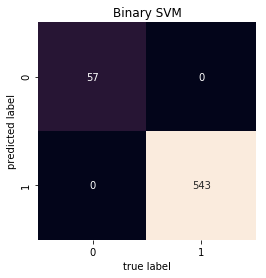

In [37]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_train, y_train_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Binary SVM')

#   encert TP       FP       veure entre diferents paràmetres

#   x  FN     encert TN      veure entre diferents paràmetres


""" Al binary fer plot de les dades i els vectors"""

Text(0.5, 1.0, 'Binary LinearSVM')

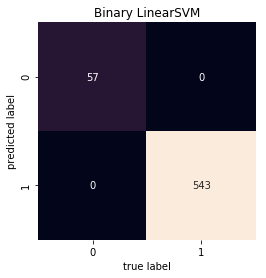

In [38]:
mat = confusion_matrix(y_train, y_train_predL)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Binary LinearSVM')



Text(0.5, 1.0, 'Multiclass SVM train')

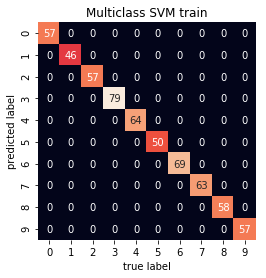

In [39]:
mat = confusion_matrix(y_trainM, y_train_predM)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Multiclass SVM train')



Text(0.5, 1.0, 'Multiclass SVM test')

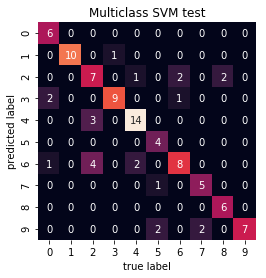

In [40]:
mat = confusion_matrix(y_testM, y_test_predM)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Multiclass SVM test')

Text(0.5, 1.0, 'Multiclass LinearSVM train')

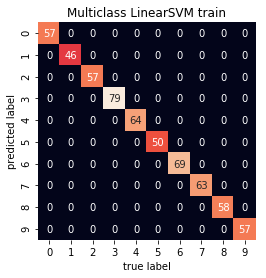

In [41]:
mat = confusion_matrix(y_trainM, y_train_predLM)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.title('Multiclass LinearSVM train')



Text(0.5, 1.0, 'Multiclass LinearSVM test')

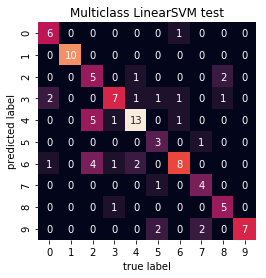

In [42]:
mat = confusion_matrix(y_testM, y_test_predLM)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.title('Multiclass LinearSVM test')



A través de la matriu de confusió es pot calcular fàcilment el accuracy, el f1-score, la precisió, el recall... Totes aquestes són mètriques que el calculen com de bé o malament ho fa un classificador tenint en compte **un llindar especific** (i.e. 0.5), o en el cas multiclasse també pot ser la classe més probable. Ara bé, si volguessim visualtizar com de bé ho fa cada classificador per **qualsevol valor del llindar**, podem veure el seu comportament a través de analitzar la [curva ROC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) i la [curva Precision-Recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html). Per a utilitzar-lo, necesiteu extreure un score de confiança o unes probabilitats de classificació per a cada una de les categories. Ho podem trobar utilitzant la funció:

* clf.decision_function(X) [per SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.decision_function) i [per LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC.decision_function)

Recordem com es calcula la curva ROC i la Precision-Recall. Per cada valor del llindar, tindrem una matriu de confusió diferent. La ROC mostra el **TPR** vs **FPR** i la PR mostra la relació entre **Precision** vs **Recall**.

True Positive Rate (TPR): del total d'exemples positius, quants hem classificat com a positiu.

$$TPR = Recall = Sensitivity = \frac{TP}{TP + FN}$$

False Positive Rate (FPR): del total d'exemples negatius, quantes falses alarmes positives apareixen.

$$FPR = 1 - Specificity = \frac{FP}{FP + TN}$$

Precision: Quina proporcio de prediccions positives es correcta.

$$Precision = \frac{TP}{TP + FP}$$

<img src="https://miro.medium.com/max/1340/1*urQ3A6h1BNgGM__Uvkwviw.png" width=600>

Si voleu refrescar o aprendre més coses sobre aquestes curves, us recomano aquest [blog](https://towardsdatascience.com/on-roc-and-precision-recall-curves-c23e9b63820c)

Exemple:

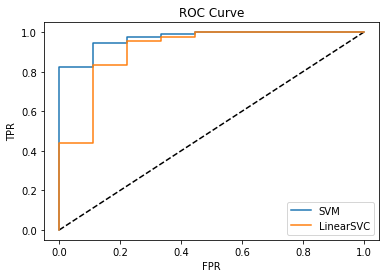

In [43]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc, RocCurveDisplay

y_score = clf.decision_function(X_test)

fpr1, tpr1, _ = roc_curve(y_test, y_test_scr, pos_label=clf.classes_[1])
#roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

y_scoreL = clfL.decision_function(X_test)

fpr2, tpr2, _ = roc_curve(y_test, y_test_scrL, pos_label=clfL.classes_[1])

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "SVM")
plt.plot(fpr2, tpr2, label= "LinearSVC")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('ROC Curve')
plt.show()

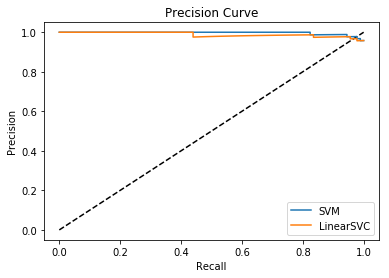

In [44]:
pr1, re1, thr1 = precision_recall_curve(y_test, y_test_scr)

pr2, re2, _ = precision_recall_curve(y_test, y_test_scrL)

plt.plot([0,1],[0,1], 'k--')
plt.plot(re1, pr1, label= "SVM")
plt.plot(re2, pr2, label= "LinearSVC")
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Precision Curve')
plt.show()

pregunta 4 https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

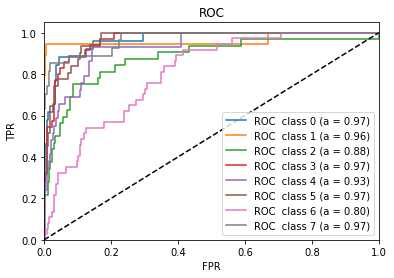

In [47]:
X = X_trainM
y = y_trainM

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2,3,4,5,6,7])
n_classes = y.shape[1]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(SVC(kernel='linear', probability=True,
                                 random_state=0))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC  class {0} (a = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

### Preguntes
1. Mostra les matrius de confusió del apartat A. En tindrem 4: (SVC-binary, LinearSVC-binary, SVC-multiclass, LinearSVC-multiclass) 
2. Compara la curva ROC pels casos binaris de SVC i LinearSVC sobre la mateixa gràfica.
3. Compara la curva PR pels casos binaris de SVC i LinearSVC sobre la mateixa gràfica.
4. Compara les curves ROC del SVC multicategoria en una mateixa gràfica.



## C. Crossvalidation (30%)

Com debeu haver comprobat, els resultats fins ara son molt alts. I es per què estem analizant el resultat sobre el mateix conjunt de aprenentatge i aquests valors no ens serveixen de gaire quan volguem aplicar el model a dades noves.

Per aquest motiu, el que intentarem de fer en aquest apartat és gestionar les dades que tenim de entrenament per a que poguem llavors trobar els millors hiperparametres que ens permetin aconseguir la millor taxa d'encert en dades mai vistes abans (per aquest motiu, no volem veure com és el test, ja que no volem fer trampes i optimitzar el nostre model sobre la sortida).

Ens basarem amb les eines de [cross-validació](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width="500px">

Ara bé, tingueu també en compte, que tan important com utilitzar dades mai vistes per optimitzar el classificador, també s'ha de fer el mateix en l'apartat del preprocessat (com per exemple al normalitzar o estandaritzar les dades). No es poden aprendre les transformacions amb dades de "test".

El cas més senzill (menys linies de codi) es fer servir la funció [cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) i [make_pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html)

Ara bé, també vull que entengueu què s'hi fa dins, aixi que farem els dos casos

Exemple:

In [20]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
scoring = ['precision_macro', 'recall_macro']
clf = SVC(kernel='linear', C=1, random_state=0)
scores = cross_validate(clf, X_trainM, y_trainM, scoring=scoring, cv=5, return_train_score=True) #change data M
print(scores['test_precision_macro'])
scores


[0.76919719 0.79759834 0.7701998  0.79380175 0.84695141]


{'fit_time': array([0.14706278, 0.1270721 , 0.12816191, 0.14399385, 0.13512397]),
 'score_time': array([0.04620218, 0.04314184, 0.04398799, 0.05020213, 0.04602623]),
 'test_precision_macro': array([0.76919719, 0.79759834, 0.7701998 , 0.79380175, 0.84695141]),
 'train_precision_macro': array([1., 1., 1., 1., 1.]),
 'test_recall_macro': array([0.76669039, 0.78055431, 0.78065559, 0.76912782, 0.8064985 ]),
 'train_recall_macro': array([1., 1., 1., 1., 1.])}

In [21]:
scoring = ['accuracy']
clf = make_pipeline(StandardScaler(), SVC(kernel='linear', C=1, random_state=0) )
scores = cross_validate(clf, X_trainM, y_trainM, scoring=scoring, cv=5, return_train_score=True)
print("La accuracy mitjana del model en el dataset multicategoria és {} ".format(np.mean(scores['test_accuracy'])))
scores


La accuracy mitjana del model en el dataset multicategoria és 0.76 


{'fit_time': array([0.17162704, 0.15132999, 0.14652276, 0.15077806, 0.15433025]),
 'score_time': array([0.0448761 , 0.04583502, 0.04774809, 0.04485083, 0.04500771]),
 'test_accuracy': array([0.75      , 0.76666667, 0.75      , 0.75833333, 0.775     ]),
 'train_accuracy': array([1., 1., 1., 1., 1.])}

In [22]:
scoring = ['accuracy']
clf = make_pipeline(StandardScaler(), SVC(kernel='linear', C=1, random_state=0) )
scores = cross_validate(clf, X_train, y_train, scoring=scoring, cv=5, return_train_score=True)
print("La accuracy mitjana del model en el dataset binari és {} ".format(np.mean(scores['test_accuracy'])))
scores

La accuracy mitjana del model en el dataset binari és 0.9550000000000001 


{'fit_time': array([0.07448483, 0.06364012, 0.06697702, 0.05349803, 0.06391692]),
 'score_time': array([0.0140419 , 0.01430416, 0.01474595, 0.01345515, 0.01612401]),
 'test_accuracy': array([0.96666667, 0.95833333, 0.975     , 0.925     , 0.95      ]),
 'train_accuracy': array([1., 1., 1., 1., 1.])}

Fit time ens indica el temps que el model ha estat entrenant ambn les dades de entrenament, mentre que score time és 
el temps que el model ha estat estimant en el test set per cada bloc de dades.

### Preguntes
1. Utilitza la funció **cross_validate** i **make_pipepline** per trobar quin **accuracy** té el model **SVC()** amb les dades normalitzades amb **StandardScaler**. [(pista)](https://scikit-learn.org/stable/modules/cross_validation.html#the-cross-validate-function-and-multiple-metric-evaluation)
2. Analitza el diccionari de camps que t'ha retornat.
3. Implementa la funció per cross-validar un model i uns parametres en concret. Utilitza la següent funció **entrena_crossvalida** com a base.
4. Compara els resultats de la pregunta C.3 amb el de la pregunta C.1.


In [23]:
from sklearn.model_selection import KFold
import time
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score





def entrena_crossvalida(model, X, y, k_folds, tp = 'binary'): 
    '''
    inputs:
       - model: el objecte que s'entrenarà
       - sample_size: el número de mostres del training set que es farán servir (en %)
       - X: caracteristiques entrenament
       - y: etiqueta entrenament
       - k_folds: número de folds d'entrenament
    '''
    
    results = { "elapsed": [], "train_accuracy": [],"train_f1_score":[], "train_ap":[],
               "val_accuracy":[],"val_f1_score":[], "val_ap":[],"elapsed":[]}

    """
    Inicialitza el FOLD objecte (i.e. KFold) amb k_folds. Cal fer shuffle a les dades?
    """
    kf = KFold(n_splits=k_folds)
    
    """
    Itera les dades per cada fold:
    """
    for i, (train_index, val_index) in tqdm(enumerate(kf.split(X))):
        t_i = time.time()
        print("CROSSVALIDANT FOLD {}".format(i))
        X_train, X_val = X.loc[train_index, :], X.loc[val_index, :]
        y_train, y_val = y[train_index], y[val_index]
 
        """
        Entrena el model amb X_train i y_train:
        """

        model.fit(X_train, y_train)

        """
        Obtenir les prediccions del model sobre el conjunt d'entrenament i sobre el conjunt de test
        """
        pred_train = model.predict(X_train)
        pred_val = model.predict(X_val)
        score_train = model.decision_function(X_train)
        score_val = model.decision_function(X_val)
        """
        Calcular el accuracy i el F1-score del train i del test
        """
        if tp == 'binary':
            results["train_f1_score"].append(f1_score(y_train, pred_train))
            results["train_ap"].append(precision_score(y_train, pred_train))
            results["val_f1_score"].append(f1_score(y_val, pred_val))
            results["val_ap"].append(precision_score(y_val, pred_val))
        results["val_accuracy"].append(accuracy_score(y_val, pred_val))
        results["train_accuracy"].append(accuracy_score(y_train, pred_train))
        results["elapsed"].append(time.time() - t_i)
        #results["scr_train"] = score_train
        #results["scr_val"] = score_val


    results["accuracy_mean"] = np.mean(results["val_accuracy"])
    results["accuracy_std"] = np.std(results["val_accuracy"])
    
    print("El model {} ha té un accuracy promig en {} folds de {} +- {}.".format(model.__class__.__name__, 
                                                                                 k_folds,
                                                                                 results["accuracy_mean"],
                                                                                 results["accuracy_std"]))
    
    
    return results
 

In [24]:
from sklearn.svm import SVC

model = SVC(C=100,kernel="linear")

entrena_crossvalida(model, X_trainM, y_trainM, k_folds=5, tp = 'multi')



CROSSVALIDANT FOLD 0
CROSSVALIDANT FOLD 1
CROSSVALIDANT FOLD 2
CROSSVALIDANT FOLD 3
CROSSVALIDANT FOLD 4

El model SVC ha té un accuracy promig en 5 folds de 0.7733333333333332 +- 0.019293061504650363.


{'elapsed': [0.5804059505462646,
  0.5602030754089355,
  0.552030086517334,
  0.5787200927734375,
  0.5470559597015381],
 'train_accuracy': [1.0, 1.0, 1.0, 1.0, 1.0],
 'train_f1_score': [],
 'train_ap': [],
 'val_accuracy': [0.75,
  0.7916666666666666,
  0.75,
  0.7916666666666666,
  0.7833333333333333],
 'val_f1_score': [],
 'val_ap': [],
 'accuracy_mean': 0.7733333333333332,
 'accuracy_std': 0.019293061504650363}

In [25]:
model = SVC(C=100,kernel="linear")

entrena_crossvalida(model, X_train, y_train, k_folds=5)


CROSSVALIDANT FOLD 0
CROSSVALIDANT FOLD 1
CROSSVALIDANT FOLD 2
CROSSVALIDANT FOLD 3
CROSSVALIDANT FOLD 4

El model SVC ha té un accuracy promig en 5 folds de 0.9566666666666667 +- 0.016996731711975938.


{'elapsed': [0.18393826484680176,
  0.17258214950561523,
  0.1836848258972168,
  0.15670180320739746,
  0.16753268241882324],
 'train_accuracy': [1.0, 1.0, 1.0, 1.0, 1.0],
 'train_f1_score': [1.0, 1.0, 1.0, 1.0, 1.0],
 'train_ap': [1.0, 1.0, 1.0, 1.0, 1.0],
 'val_accuracy': [0.95,
  0.95,
  0.9833333333333333,
  0.9333333333333333,
  0.9666666666666667],
 'val_f1_score': [0.9724770642201834,
  0.9727272727272728,
  0.9911504424778761,
  0.96,
  0.9821428571428571],
 'val_ap': [0.9636363636363636,
  0.963963963963964,
  0.9911504424778761,
  0.9696969696969697,
  0.9821428571428571],
 'accuracy_mean': 0.9566666666666667,
 'accuracy_std': 0.016996731711975938}

## D. Hyperparameter search (20%)

Finalment, crossvalidar un model serveix per tenir una idea bastant aproximada del performance que hauriem d'aconseguir amb un model, unes dades i uns hiperparametres concrets sobre unes dades mai vistes abans. Llavors, si tenim unes dades d'entrenament donades, el que hem d'optimitzar és buscar quin model i quins hiperparametres s'ajusten millor a les nostres necesitats (i.e. més precisió, la millor precisió tenint el compte el cost...).

Per fer això, existeix la búsqueda de hiperparametres. En el cas de SVM, per exemple, podriem optimitzar la C (la força de la regularització), el kernel a utilitzar, els parametres propis de cada kernel (degree  pel 'poly', gamma per ‘rbf’, ‘poly’ i ‘sigmoid’...).

Un exemple de búsqueda de hiperparametres es el [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Aqui, es faran les N combinacions segons els parametres i els valors especificats.

Una altra opció és utilitzar una búsqueda Aleatoria del valors, i esperar a trobar la millor solució. D'això se'n diu [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). En aquest cas, pots definir el **n_iter** que vols que provi. Es a dir, si dius que n_iter=10, farà 10 proves amb diferents valors dels hiperparametres.

Exemple:

In [26]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform#, loguniform
from sklearn.svm import SVC

model = SVC()
distributions = dict(C=uniform(loc=0.001, scale=10),
                     kernel=['poly', 'rbf','linear'],
                     gamma=uniform(loc=0.001, scale=10),
                     degree= [2,3,4,5])

clf = RandomizedSearchCV(model, distributions, random_state=0, n_iter=10)
search = clf.fit(X_trainM, y_trainM)
print("BEST PARAMS: {}".format(search.best_params_))
print("BEST SCORE: {}".format(search.best_score_))

BEST PARAMS: {'C': 6.236636967859724, 'degree': 4, 'gamma': 4.376872112626925, 'kernel': 'linear'}
BEST SCORE: 0.775


In [27]:
from sklearn.model_selection import GridSearchCV
#param_grid = {'C': uniform(loc=0.001, scale=10), 'gamma': uniform(loc=0.001, scale=10), 'kernel': ['rbf', 'linear','poly','sigmoid'], 
 #             'degree' : [2,3,5,7]} 
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'linear','sigmoid'], 'degree':[3,4]} 
grid = GridSearchCV(SVC(), param_grid, refit=True,verbose=4) #refit=True,verbose=4
grid.fit(X_trainM, y_trainM) # combinacions valides
print("BEST PARAMS: {}".format(grid.best_params_))
print("BEST SCORE: {}".format(grid.best_score_))




Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] C=0.1, degree=3, gamma=1, kernel=rbf ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.1, degree=3, gamma=1, kernel=rbf, score=0.133, total=   0.5s
[CV] C=0.1, degree=3, gamma=1, kernel=rbf ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  C=0.1, degree=3, gamma=1, kernel=rbf, score=0.133, total=   0.5s
[CV] C=0.1, degree=3, gamma=1, kernel=rbf ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV]  C=0.1, degree=3, gamma=1, kernel=rbf, score=0.133, total=   0.5s
[CV] C=0.1, degree=3, gamma=1, kernel=rbf ............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.5s remaining:    0.0s


[CV]  C=0.1, degree=3, gamma=1, kernel=rbf, score=0.133, total=   0.5s
[CV] C=0.1, degree=3, gamma=1, kernel=rbf ............................
[CV]  C=0.1, degree=3, gamma=1, kernel=rbf, score=0.125, total=   0.5s
[CV] C=0.1, degree=3, gamma=1, kernel=linear .........................
[CV]  C=0.1, degree=3, gamma=1, kernel=linear, score=0.750, total=   0.2s
[CV] C=0.1, degree=3, gamma=1, kernel=linear .........................
[CV]  C=0.1, degree=3, gamma=1, kernel=linear, score=0.775, total=   0.2s
[CV] C=0.1, degree=3, gamma=1, kernel=linear .........................
[CV]  C=0.1, degree=3, gamma=1, kernel=linear, score=0.767, total=   0.2s
[CV] C=0.1, degree=3, gamma=1, kernel=linear .........................
[CV]  C=0.1, degree=3, gamma=1, kernel=linear, score=0.775, total=   0.2s
[CV] C=0.1, degree=3, gamma=1, kernel=linear .........................
[CV]  C=0.1, degree=3, gamma=1, kernel=linear, score=0.808, total=   0.2s
[CV] C=0.1, degree=3, gamma=1, kernel=sigmoid ................

[CV]  C=0.1, degree=3, gamma=0.001, kernel=sigmoid, score=0.125, total=   0.4s
[CV] C=0.1, degree=4, gamma=1, kernel=rbf ............................
[CV]  C=0.1, degree=4, gamma=1, kernel=rbf, score=0.133, total=   0.5s
[CV] C=0.1, degree=4, gamma=1, kernel=rbf ............................
[CV]  C=0.1, degree=4, gamma=1, kernel=rbf, score=0.133, total=   0.4s
[CV] C=0.1, degree=4, gamma=1, kernel=rbf ............................
[CV]  C=0.1, degree=4, gamma=1, kernel=rbf, score=0.133, total=   0.4s
[CV] C=0.1, degree=4, gamma=1, kernel=rbf ............................
[CV]  C=0.1, degree=4, gamma=1, kernel=rbf, score=0.133, total=   0.4s
[CV] C=0.1, degree=4, gamma=1, kernel=rbf ............................
[CV]  C=0.1, degree=4, gamma=1, kernel=rbf, score=0.125, total=   0.4s
[CV] C=0.1, degree=4, gamma=1, kernel=linear .........................
[CV]  C=0.1, degree=4, gamma=1, kernel=linear, score=0.750, total=   0.2s
[CV] C=0.1, degree=4, gamma=1, kernel=linear .....................

[CV]  C=0.1, degree=4, gamma=0.001, kernel=sigmoid, score=0.133, total=   0.4s
[CV] C=0.1, degree=4, gamma=0.001, kernel=sigmoid ....................
[CV]  C=0.1, degree=4, gamma=0.001, kernel=sigmoid, score=0.133, total=   0.4s
[CV] C=0.1, degree=4, gamma=0.001, kernel=sigmoid ....................
[CV]  C=0.1, degree=4, gamma=0.001, kernel=sigmoid, score=0.133, total=   0.4s
[CV] C=0.1, degree=4, gamma=0.001, kernel=sigmoid ....................
[CV]  C=0.1, degree=4, gamma=0.001, kernel=sigmoid, score=0.133, total=   0.4s
[CV] C=0.1, degree=4, gamma=0.001, kernel=sigmoid ....................
[CV]  C=0.1, degree=4, gamma=0.001, kernel=sigmoid, score=0.125, total=   0.4s
[CV] C=1, degree=3, gamma=1, kernel=rbf ..............................
[CV] .. C=1, degree=3, gamma=1, kernel=rbf, score=0.133, total=   0.5s
[CV] C=1, degree=3, gamma=1, kernel=rbf ..............................
[CV] .. C=1, degree=3, gamma=1, kernel=rbf, score=0.133, total=   0.5s
[CV] C=1, degree=3, gamma=1, kernel=r

[CV]  C=1, degree=3, gamma=0.001, kernel=linear, score=0.775, total=   0.2s
[CV] C=1, degree=3, gamma=0.001, kernel=linear .......................
[CV]  C=1, degree=3, gamma=0.001, kernel=linear, score=0.808, total=   0.2s
[CV] C=1, degree=3, gamma=0.001, kernel=sigmoid ......................
[CV]  C=1, degree=3, gamma=0.001, kernel=sigmoid, score=0.133, total=   0.4s
[CV] C=1, degree=3, gamma=0.001, kernel=sigmoid ......................
[CV]  C=1, degree=3, gamma=0.001, kernel=sigmoid, score=0.133, total=   0.4s
[CV] C=1, degree=3, gamma=0.001, kernel=sigmoid ......................
[CV]  C=1, degree=3, gamma=0.001, kernel=sigmoid, score=0.133, total=   0.4s
[CV] C=1, degree=3, gamma=0.001, kernel=sigmoid ......................
[CV]  C=1, degree=3, gamma=0.001, kernel=sigmoid, score=0.133, total=   0.4s
[CV] C=1, degree=3, gamma=0.001, kernel=sigmoid ......................
[CV]  C=1, degree=3, gamma=0.001, kernel=sigmoid, score=0.125, total=   0.4s
[CV] C=1, degree=4, gamma=1, kernel=r

[CV]  C=1, degree=4, gamma=0.001, kernel=linear, score=0.775, total=   0.2s
[CV] C=1, degree=4, gamma=0.001, kernel=linear .......................
[CV]  C=1, degree=4, gamma=0.001, kernel=linear, score=0.767, total=   0.2s
[CV] C=1, degree=4, gamma=0.001, kernel=linear .......................
[CV]  C=1, degree=4, gamma=0.001, kernel=linear, score=0.775, total=   0.2s
[CV] C=1, degree=4, gamma=0.001, kernel=linear .......................
[CV]  C=1, degree=4, gamma=0.001, kernel=linear, score=0.808, total=   0.2s
[CV] C=1, degree=4, gamma=0.001, kernel=sigmoid ......................
[CV]  C=1, degree=4, gamma=0.001, kernel=sigmoid, score=0.133, total=   0.4s
[CV] C=1, degree=4, gamma=0.001, kernel=sigmoid ......................
[CV]  C=1, degree=4, gamma=0.001, kernel=sigmoid, score=0.133, total=   0.4s
[CV] C=1, degree=4, gamma=0.001, kernel=sigmoid ......................
[CV]  C=1, degree=4, gamma=0.001, kernel=sigmoid, score=0.133, total=   0.4s
[CV] C=1, degree=4, gamma=0.001, kernel

[CV]  C=10, degree=3, gamma=0.001, kernel=rbf, score=0.133, total=   0.5s
[CV] C=10, degree=3, gamma=0.001, kernel=rbf .........................
[CV]  C=10, degree=3, gamma=0.001, kernel=rbf, score=0.125, total=   0.5s
[CV] C=10, degree=3, gamma=0.001, kernel=linear ......................
[CV]  C=10, degree=3, gamma=0.001, kernel=linear, score=0.750, total=   0.2s
[CV] C=10, degree=3, gamma=0.001, kernel=linear ......................
[CV]  C=10, degree=3, gamma=0.001, kernel=linear, score=0.775, total=   0.2s
[CV] C=10, degree=3, gamma=0.001, kernel=linear ......................
[CV]  C=10, degree=3, gamma=0.001, kernel=linear, score=0.767, total=   0.2s
[CV] C=10, degree=3, gamma=0.001, kernel=linear ......................
[CV]  C=10, degree=3, gamma=0.001, kernel=linear, score=0.775, total=   0.2s
[CV] C=10, degree=3, gamma=0.001, kernel=linear ......................
[CV]  C=10, degree=3, gamma=0.001, kernel=linear, score=0.808, total=   0.2s
[CV] C=10, degree=3, gamma=0.001, kernel=

[CV]  C=10, degree=4, gamma=0.001, kernel=rbf, score=0.133, total=   0.5s
[CV] C=10, degree=4, gamma=0.001, kernel=rbf .........................
[CV]  C=10, degree=4, gamma=0.001, kernel=rbf, score=0.133, total=   0.5s
[CV] C=10, degree=4, gamma=0.001, kernel=rbf .........................
[CV]  C=10, degree=4, gamma=0.001, kernel=rbf, score=0.133, total=   0.5s
[CV] C=10, degree=4, gamma=0.001, kernel=rbf .........................
[CV]  C=10, degree=4, gamma=0.001, kernel=rbf, score=0.133, total=   0.5s
[CV] C=10, degree=4, gamma=0.001, kernel=rbf .........................
[CV]  C=10, degree=4, gamma=0.001, kernel=rbf, score=0.125, total=   0.5s
[CV] C=10, degree=4, gamma=0.001, kernel=linear ......................
[CV]  C=10, degree=4, gamma=0.001, kernel=linear, score=0.750, total=   0.2s
[CV] C=10, degree=4, gamma=0.001, kernel=linear ......................
[CV]  C=10, degree=4, gamma=0.001, kernel=linear, score=0.775, total=   0.2s
[CV] C=10, degree=4, gamma=0.001, kernel=linear ..

[CV]  C=100, degree=3, gamma=0.01, kernel=sigmoid, score=0.133, total=   0.4s
[CV] C=100, degree=3, gamma=0.01, kernel=sigmoid .....................
[CV]  C=100, degree=3, gamma=0.01, kernel=sigmoid, score=0.133, total=   0.4s
[CV] C=100, degree=3, gamma=0.01, kernel=sigmoid .....................
[CV]  C=100, degree=3, gamma=0.01, kernel=sigmoid, score=0.125, total=   0.4s
[CV] C=100, degree=3, gamma=0.001, kernel=rbf ........................
[CV]  C=100, degree=3, gamma=0.001, kernel=rbf, score=0.133, total=   0.5s
[CV] C=100, degree=3, gamma=0.001, kernel=rbf ........................
[CV]  C=100, degree=3, gamma=0.001, kernel=rbf, score=0.133, total=   0.5s
[CV] C=100, degree=3, gamma=0.001, kernel=rbf ........................
[CV]  C=100, degree=3, gamma=0.001, kernel=rbf, score=0.133, total=   0.5s
[CV] C=100, degree=3, gamma=0.001, kernel=rbf ........................
[CV]  C=100, degree=3, gamma=0.001, kernel=rbf, score=0.133, total=   0.5s
[CV] C=100, degree=3, gamma=0.001, kerne

[CV]  C=100, degree=4, gamma=0.01, kernel=linear, score=0.775, total=   0.2s
[CV] C=100, degree=4, gamma=0.01, kernel=linear ......................
[CV]  C=100, degree=4, gamma=0.01, kernel=linear, score=0.808, total=   0.2s
[CV] C=100, degree=4, gamma=0.01, kernel=sigmoid .....................
[CV]  C=100, degree=4, gamma=0.01, kernel=sigmoid, score=0.133, total=   0.5s
[CV] C=100, degree=4, gamma=0.01, kernel=sigmoid .....................
[CV]  C=100, degree=4, gamma=0.01, kernel=sigmoid, score=0.133, total=   0.5s
[CV] C=100, degree=4, gamma=0.01, kernel=sigmoid .....................
[CV]  C=100, degree=4, gamma=0.01, kernel=sigmoid, score=0.133, total=   0.5s
[CV] C=100, degree=4, gamma=0.01, kernel=sigmoid .....................
[CV]  C=100, degree=4, gamma=0.01, kernel=sigmoid, score=0.133, total=   0.4s
[CV] C=100, degree=4, gamma=0.01, kernel=sigmoid .....................
[CV]  C=100, degree=4, gamma=0.01, kernel=sigmoid, score=0.125, total=   0.5s
[CV] C=100, degree=4, gamma=0.

[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:  2.9min finished


BEST PARAMS: {'C': 0.1, 'degree': 3, 'gamma': 1, 'kernel': 'linear'}
BEST SCORE: 0.775


In [28]:
print("BEST PARAMS: {}".format(grid.best_params_))
print("BEST SCORE: {}".format(grid.best_score_))



BEST PARAMS: {'C': 0.1, 'degree': 3, 'gamma': 1, 'kernel': 'linear'}
BEST SCORE: 0.775


In [29]:
grid_predictions = grid.predict(X_testM)
accuracy_score(y_testM, grid_predictions)

0.76

In [30]:
start = time.time()
final = make_pipeline(StandardScaler(), SVC(C = grid.best_params_['C'],kernel=grid.best_params_['kernel'],
                                            gamma = grid.best_params_['gamma']))
final.fit(X_trainM, y_trainM)
y_train_predM = final.predict(X_trainM)
y_test_predM = clfM.predict(X_testM)

y_train_scrM = final.decision_function(X_trainM)
y_test_scrM = final.decision_function(X_testM) 

accuracy_trainM = accuracy_score(y_trainM, y_train_predM)
accuracy_testM = accuracy_score(y_testM, y_test_predM)

print("Time is {} ".format(time.time()-start))
print("The accuracy on training is {}".format(accuracy_trainM))
print("The accuracy on test is {}".format(accuracy_testM))

Time is 0.8274109363555908 
The accuracy on training is 1.0
The accuracy on test is 0.76


In [31]:
datasetTotal = load_dataset('fashion-mnist_train.csv')
y_trainT = datasetTotal["label"]
X_trainT = datasetTotal.drop("label", axis="columns")

dataset_Ttest = load_dataset('fashion-mnist_test.csv')
y_testT = dataset_Ttest["label"]
X_testT = dataset_Ttest.drop("label", axis="columns")

In [43]:
y_test_predT = final.predict(X_testT)
accuracy_testT = accuracy_score(y_testT, y_test_predT)
y_test_scrT = final.decision_function(X_testT) 


accuracy_testT

0.7713

Text(0.5, 1.0, 'Total dataset')

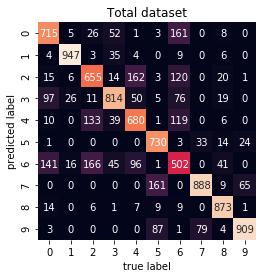

In [44]:
mat = confusion_matrix(y_testT, y_test_predT)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Total dataset')

El sistema entrenat en el dataset petit ens serveix per el datasaet gran, ja que el contingut és el mateix,
l'única diferència és que en el dataset gran tenim més exemples per el model, però el tipus de dades és igual. 
És per això que obtenim una bona aproximació.

### Preguntes
1. Fes una estimació (sense implementar-ho) del número de crosvalidacions que hauries de provar pels diferents parametres i les seves combinacions. Per exemple, considerant només el kernel 'rbf'. Quins hiperparametres poden afectar al resultat final, i quins valors per cada parametre provaries. Conta la seva combinació i multiplicau pel temps que triga a fer una sola crossvalidació.

2. Utilitza **GridSearch** per fer la búsqueda de parametres. Tingues en compte els tipus parametres i les quantitats de valors a provar. Quins hi posaries si no vols que trigui més de 30 minuts.

3. Utilitza **RandomizedSearchCV** per fer búscar els parametres. No permetis que trigui més de 30 minuts. Quins valors ha provat?

4. Quin dels dos mètodes ha donat millor resultat, tenint en compte les restriccions de temps de 30 minuts de cerca.

5. Ara si, evalua el millor model sobre el conjunt de test **'fashion-mnist_test_small.csv'**.

6. Finalment, amb el millor model que hagis aconseguit sobre 'fashion-mnist_train_small.csv', fes un test sobre 'fashion-mnist_test.csv'. Quin resultat obtens? Son similars als de D.5??


## E. Extra (+10% màxim 10 pts a la practica)

El qui ho vulgui, pot realitzar un entrenament amb les dades completes (i.e. fashion-mnist_train.csv) i fer el test sobre fashion-mnist_test.csv.

Tingueu en compte que l'entrenament pot ser **molt costós** (varies hores sense fer crosvalidació amb el SVC). Us recomano de només fer servir **LinearSVC** (Podeu limitar el numero de max_iter..)

### Preguntes
1. Els millors parametres trobats en els apartats anteriors segueixent funcionant aqui?
2. Quin resultat has obtingut al tenir moltes més dades d'entrenament? 
3. Compareu els vostres resultats amb [l'estat de l'art obtinguts amb sklearn o deep learning](https://github.com/zalandoresearch/fashion-mnist#benchmark)



